In [2]:
# src/model.py
import numpy as np
from dataclasses import dataclass
from typing import Tuple, Dict
from scipy.integrate import solve_ivp

# =========================
# Weekly SEIRC-C (with C(t))
# =========================
# States: S, E, I, R, C, A, D
# A: cumulative new infections (incidence integral)  dA = sigma * E
# D: cumulative deaths                               dD = mu_eff * I
# Time unit: weeks
kappa = 5000
@dataclass
class Params:
    N: float
    beta1: float     # direct (short-cycle) transmission rate, per week
    beta2: float     # environmental (long-cycle) transmission rate, per week
    sigma: float     # incubation rate (E->I), per week
    gamma: float     # recovery rate, per week
    mu: float        # disease-induced mortality rate, per week
    delta: float     # environmental loss/clearance rate, per week
    eta: float       # shedding rate into environment, per week
    epsilon: float   # baseline environmental growth/retention, per week
    kappa: float     # environmental carrying capacity (for C)
    # Controls (constant in scenarios; set to 0 for baseline)
    u_vac: float = 0.0     # vaccination / susceptibility reduction [0,1]
    u_san: float = 0.0     # sanitation (environmental clearance) [0,1]
    u_treat: float = 0.0   # treatment (↑gamma, ↓mu) [0,1]

# --- replace your ControlGains with this ---
@dataclass
class ControlGains:
    # Sanitation knobs
    k_s_to_delta: float = 9.0    # δ_eff = δ * (1 + 9*u_san)  → up to 10×
    k_s_to_beta2: float = 0.98   # β2_eff = β2 * max(0, 1 - 0.98*u_san) → down to ~2%
    k_s_to_eta:   float = 0.6    # η_eff  = η  * (1 - 0.6*u_san)
    k_s_to_eps:   float = 0.8    # ε_eff  = ε  * (1 - 0.8*u_san)

    # Vaccination (susceptibility scaling)
    k_v_to_beta: float = 1.0     # multiplies (1 - u_vac) on FOI

    # Treatment (↑γ, ↓μ)
    k_t_to_gamma: float = 3.0    # γ_eff = γ * (1 + 3*u_treat)
    k_t_to_mu:    float = 0.9    # μ_eff = μ * (1 - 0.9*u_treat)

def _effective_params(p: Params, k: ControlGains):
    u_v  = float(np.clip(p.u_vac,  0, 1))
    u_s  = float(np.clip(p.u_san,  0, 1))
    u_t  = float(np.clip(p.u_treat,0, 1))

    susc_scale = (1.0 - k.k_v_to_beta * u_v)

    # Sanitation effects
    delta_eff = p.delta * (1.0 + k.k_s_to_delta * u_s)
    beta2_eff = p.beta2 * max(0.0, 1.0 - k.k_s_to_beta2 * u_s)
    eta_eff   = p.eta   * (1.0 - k.k_s_to_eta   * u_s)
    eps_eff   = p.epsilon * (1.0 - k.k_s_to_eps * u_s)

    # Treatment effects
    gamma_eff = p.gamma * (1.0 + k.k_t_to_gamma * u_t)
    mu_eff    = p.mu    * (1.0 - k.k_t_to_mu    * u_t)

    return dict(
        susc_scale=susc_scale, delta_eff=delta_eff, beta2_eff=beta2_eff,
        eta_eff=eta_eff, eps_eff=eps_eff, gamma_eff=gamma_eff, mu_eff=mu_eff
    )

def rhs(t, y, p: Params, gains: ControlGains):
    S, E, I, R, C, A, D = y
    eff = _effective_params(p, gains)

    # FOI with sanitation-adjusted β2 and vaccination scaling
    lambda_dir = p.beta1 * I / p.N
    lambda_env = eff["beta2_eff"] * C / (C + kappa)     # see tweak B below
    lambda_tot = eff["susc_scale"] * (lambda_dir + lambda_env)

    dS = - lambda_tot * S
    dE =   lambda_tot * S - p.sigma * E
    dI =   p.sigma * E - eff["gamma_eff"] * I - eff["mu_eff"] * I
    dR =   eff["gamma_eff"] * I

    # C dynamics with sanitation-adjusted δ, η, ε
    dC =   eff["eta_eff"] * I * (1.0 - C / p.kappa) + eff["eps_eff"] * C - eff["delta_eff"] * C

    dA = p.sigma * E
    dD = eff["mu_eff"] * I
    return np.array([dS, dE, dI, dR, dC, dA, dD], float)

def simulate(
    t_weeks: np.ndarray,
    y0: Tuple[float, float, float, float, float, float, float],
    params: Params,
    gains: ControlGains = ControlGains(),
    rtol: float = 1e-6,
    atol: float = 1e-8,
    method: str = "LSODA"
):
    t_span = (float(t_weeks[0]), float(t_weeks[-1]))
    sol = solve_ivp(
        lambda t, y: rhs(t, y, params, gains),
        t_span, np.array(y0, float),
        t_eval=t_weeks, rtol=rtol, atol=atol, method=method
    )
    if not sol.success:
        raise RuntimeError("ODE solver failed: " + sol.message)

    S, E, I, R, C, A, D = sol.y
    # Weekly incidence & deaths by differencing cumulative integrals
    # (First entry is week-aligned; prepend 0 to diff over grid)
    A_diff = np.diff(A, prepend=A[0])
    D_diff = np.diff(D, prepend=D[0])

    outputs = dict(
        t=sol.t, S=S, E=E, I=I, R=R, C=C,
        cum_inc=A, cum_deaths=D,
        weekly_cases=A_diff, weekly_deaths=D_diff
    )
    return outputs

Fitted parameters:
   beta1 = 0.652339
   beta2 = 0.305659
   sigma = 4.88688
   gamma = 1.51793
      mu = 0.0416591
   delta = 2.03361
     eta = 0.0436944
 epsilon = 0.0466731
   kappa = 198.601
      I0 = 52.6129
      C0 = 0.643097
Saved plots to ./plots


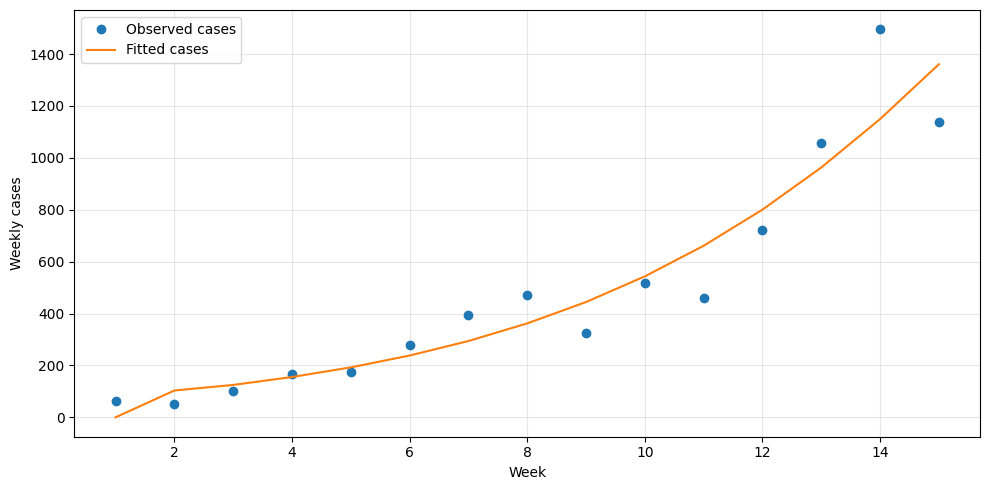

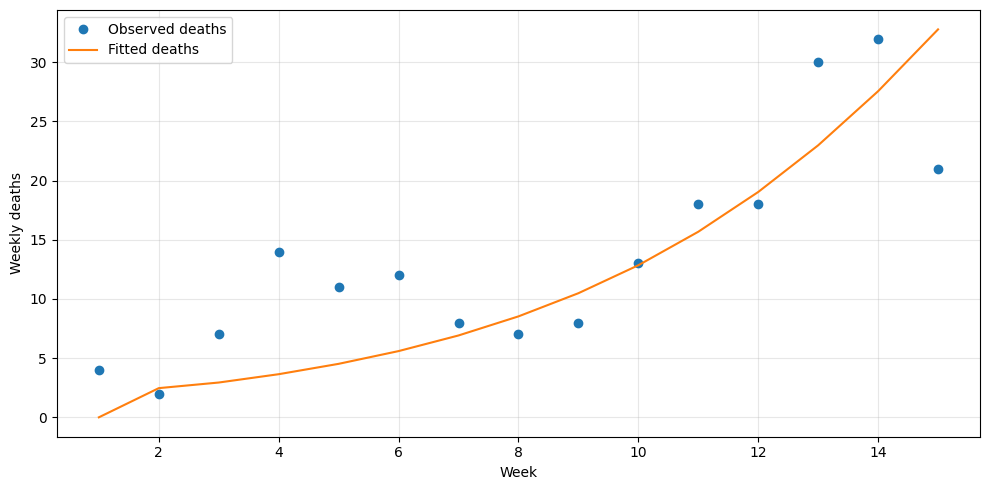

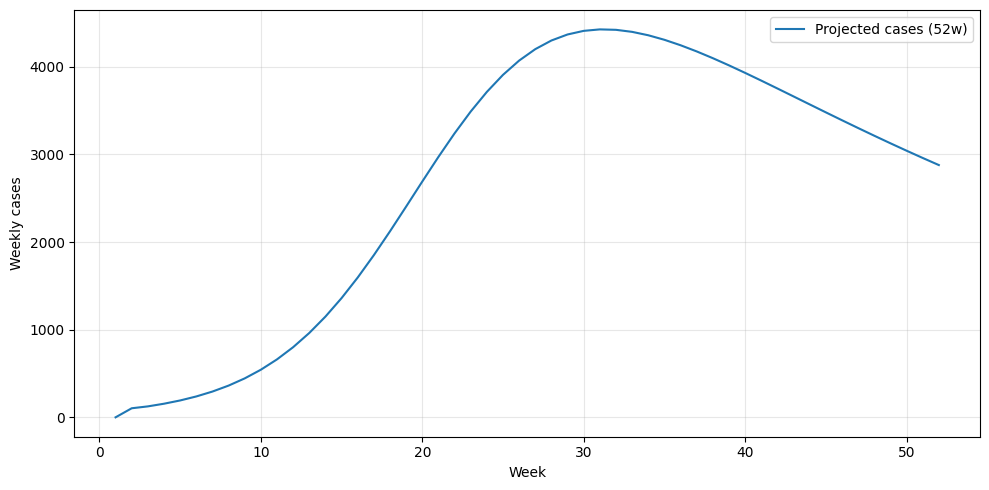

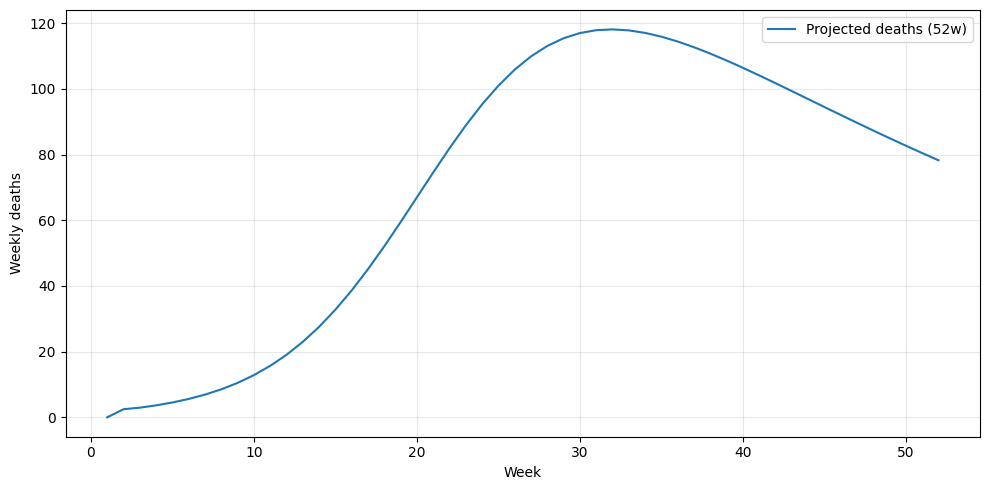

In [3]:
# src/fit_and_project.py
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from scipy.optimize import least_squares
from model import Params, ControlGains, simulate

# ==============================
# Weekly data (cases & deaths)
# ==============================
weeks = np.arange(1, 16, dtype=float)
cases_obs = np.array([64, 52, 101, 168, 175,
                      279, 393, 472, 324, 517,
                      460, 722, 1059, 1495, 1140], float)
deaths_obs = np.array([4, 2, 7, 14, 11,
                       12, 8, 7, 8, 13,
                       18, 18, 30, 32, 21], float)

# ========================================
# Initial conditions and parameters (weekly)
# ========================================
N_POP = 1_000_000.0
t_fit = weeks

# We will FIT I0 and C0 (prevalence & environment at start).
# E0 initialized as 0.5*I0; R0=0; A0=D0=0; S0=N - (E0+I0+R0)
def pack_params(theta):
    # theta = [beta1, beta2, sigma, gamma, mu, delta, eta, epsilon, kappa, I0, C0]
    return dict(
        beta1   = theta[0],
        beta2   = theta[1],
        sigma   = theta[2],
        gamma   = theta[3],
        mu      = theta[4],
        delta   = theta[5],
        eta     = theta[6],
        epsilon = theta[7],
        kappa   = theta[8],
        I0      = theta[9],
        C0      = theta[10],
    )

# Biologically grounded initials/bounds (WEEKLY units)
theta0 = np.array([
    0.7,    # beta1
    0.5,    # beta2
    4.0,    # sigma  (≈ 1/1.75 wk)
    1.5,    # gamma  (≈ 1/0.67 wk)
    0.02,   # mu     (1-5% weekly hazard typical; context-dependent)
    2.0,    # delta  (env half-life ~ 2-3 days)
    0.15,   # eta
    0.05,   # epsilon
    200.0,  # kappa
    50.0,   # I0     (initial infectious prevalence)
    5.0     # C0     (initial environmental level)
], float)

lower = np.array([
    0.0, 0.0, 1.4, 1.0, 0.001, 0.5, 0.0, 0.0,   50.0,  1.0,  0.0
], float)
upper = np.array([
    3.0, 3.0, 14.0, 3.0, 0.2,   7.0, 2.0,  0.5, 500.0, 1e4,  5e3
], float)

def simulate_from_theta(theta, u_vac=0.0, u_san=0.0, u_treat=0.0):
    pmap = pack_params(theta)
    pars = Params(
        N=N_POP,
        beta1=pmap["beta1"], beta2=pmap["beta2"], sigma=pmap["sigma"],
        gamma=pmap["gamma"], mu=pmap["mu"], delta=pmap["delta"],
        eta=pmap["eta"], epsilon=pmap["epsilon"], kappa=pmap["kappa"],
        u_vac=u_vac, u_san=u_san, u_treat=u_treat
    )
    I0 = max(1.0, pmap["I0"])
    E0 = 0.5 * I0
    R0 = 0.0
    C0 = max(0.0, pmap["C0"])
    S0 = pars.N - (E0 + I0 + R0)
    A0 = 0.0
    D0 = 0.0
    y0 = (S0, E0, I0, R0, C0, A0, D0)
    return simulate(t_fit, y0, pars)

# Joint residuals (cases & deaths), with mild weighting to deaths
def residuals(theta):
    out = simulate_from_theta(theta)
    # Align to observed weeks
    pred_cases = out["weekly_cases"]
    pred_deaths = out["weekly_deaths"]
    # weights: scale deaths residuals to similar magnitude
    w_cases = 1.0
    w_deaths = 5.0
    return np.concatenate([
        w_cases * (pred_cases - cases_obs),
        w_deaths * (pred_deaths - deaths_obs)
    ])

def main():
    sol = least_squares(
        residuals, theta0, bounds=(lower, upper),
        xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=20000
    )
    theta_hat = sol.x
    print("Fitted parameters:")
    names = ["beta1","beta2","sigma","gamma","mu","delta","eta","epsilon","kappa","I0","C0"]
    for n, v in zip(names, theta_hat):
        print(f"{n:>8s} = {v:.6g}")

    # 52-week projection (baseline)
    weeks_year = np.arange(t_fit[0], t_fit[0] + 52, dtype=float)
    # re-simulate on projection grid
    from model import Params as P
    pmap = pack_params(theta_hat)
    pars = P(
        N=N_POP, beta1=pmap["beta1"], beta2=pmap["beta2"], sigma=pmap["sigma"],
        gamma=pmap["gamma"], mu=pmap["mu"], delta=pmap["delta"],
        eta=pmap["eta"], epsilon=pmap["epsilon"], kappa=pmap["kappa"]
    )
    I0 = max(1.0, pmap["I0"])
    E0 = 0.5 * I0
    R0 = 0.0
    C0 = max(0.0, pmap["C0"])
    S0 = pars.N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0, C0, 0.0, 0.0)

    out_fit = simulate(t_fit, y0, pars)
    # Projection uses same y0 but longer time vector
    from model import simulate as sim_proj
    out_proj = sim_proj(weeks_year, y0, pars)

    # Plots
    import os
    os.makedirs("../plots", exist_ok=True)

    # Fit vs data (cases)
    plt.figure(figsize=(10,5))
    plt.plot(t_fit, cases_obs, "o", label="Observed cases")
    plt.plot(out_fit["t"], out_fit["weekly_cases"], "-", label="Fitted cases")
    plt.xlabel("Week")
    plt.ylabel("Weekly cases")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/fit_cases.png", dpi=200)

    # Fit vs data (deaths)
    plt.figure(figsize=(10,5))
    plt.plot(t_fit, deaths_obs, "o", label="Observed deaths")
    plt.plot(out_fit["t"], out_fit["weekly_deaths"], "-", label="Fitted deaths")
    plt.xlabel("Week")
    plt.ylabel("Weekly deaths")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/fit_deaths.png", dpi=200)

    # 1-year projections (cases & deaths)
    plt.figure(figsize=(10,5))
    plt.plot(out_proj["t"], out_proj["weekly_cases"], "-", label="Projected cases (52w)")
    plt.xlabel("Week"); plt.ylabel("Weekly cases")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/proj_cases_52w.png", dpi=200)

    plt.figure(figsize=(10,5))
    plt.plot(out_proj["t"], out_proj["weekly_deaths"], "-", label="Projected deaths (52w)")
    plt.xlabel("Week"); plt.ylabel("Weekly deaths")
    plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/proj_deaths_52w.png", dpi=200)

    print("Saved plots to ./plots")

if __name__ == "__main__":
    main()

Scenario plots saved in ./plots


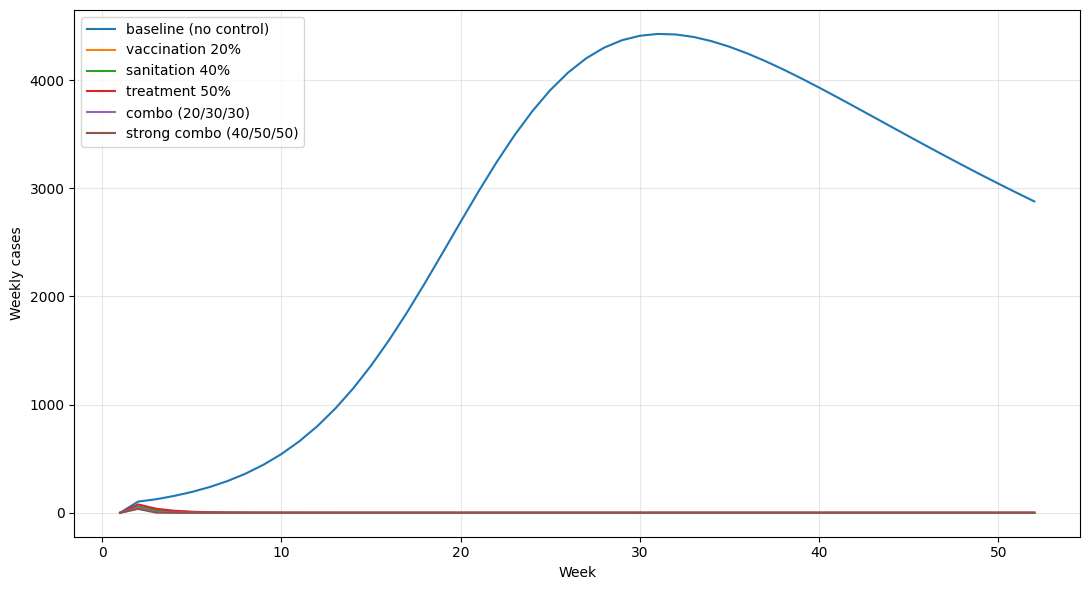

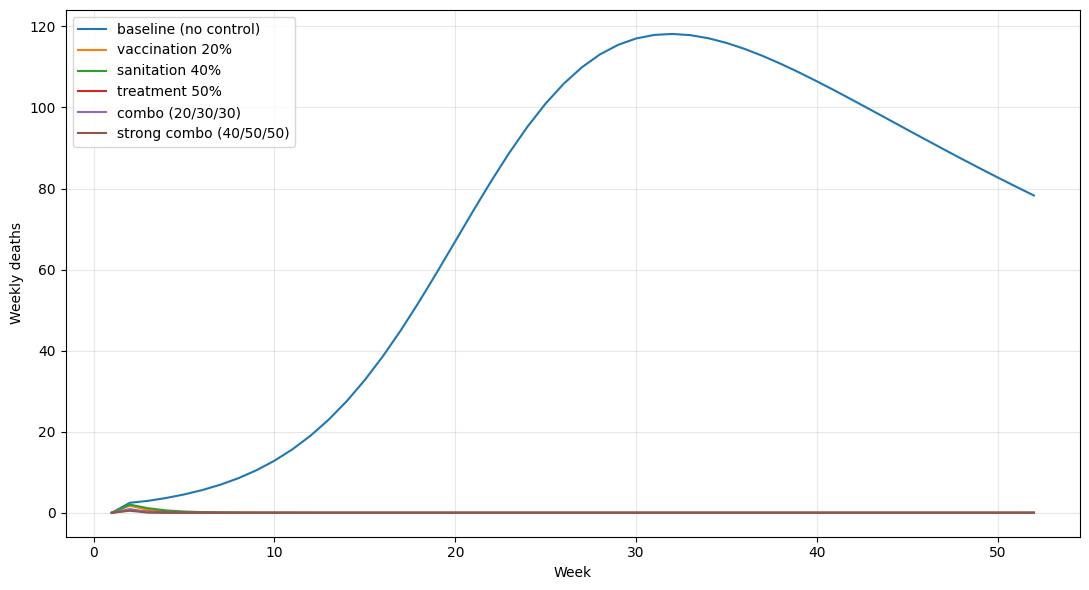

In [9]:
# src/scenarios.py
import numpy as np
import matplotlib.pyplot as plt
from fit_and_project import pack_params, theta0, lower, upper, least_squares, residuals
from model import Params, simulate

# After fitting (reuse least_squares & residuals from fit_and_project)
def fit_theta():
    sol = least_squares(residuals, theta0, bounds=(lower, upper),
                        xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=20000)
    return sol.x

def run_scenarios(theta_hat):
    p = pack_params(theta_hat)
    base = Params(N=1_000_000.0, beta1=p["beta1"], beta2=p["beta2"], sigma=p["sigma"],
                  gamma=p["gamma"], mu=p["mu"], delta=p["delta"],
                  eta=p["eta"], epsilon=p["epsilon"], kappa=p["kappa"])

    # Initial conditions based on fitted prevalence/environment
    I0 = max(1.0, p["I0"]); E0 = 0.5*I0; R0 = 0.0
    C0 = max(0.0, p["C0"]); S0 = base.N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0, C0, 0.0, 0.0)

    weeks_year = np.arange(1.0, 53.0)

    scenarios = {
        "baseline (no control)" : dict(u_vac=0.0, u_san=0.0, u_treat=0.0),
        "vaccination 20%"       : dict(u_vac=0.2, u_san=0.0, u_treat=0.0),
        "sanitation 40%"        : dict(u_vac=0.0, u_san=0.40, u_treat=0.0),
        "treatment 50%"         : dict(u_vac=0.0, u_san=0.0, u_treat=0.5),
        "combo (20/30/30)"      : dict(u_vac=0.2, u_san=0.3, u_treat=0.3),
        "strong combo (40/50/50)":dict(u_vac=0.4, u_san=0.5, u_treat=0.5)
    }

    outs = {}
    for name, ctrl in scenarios.items():
        pars = Params(**{**base.__dict__, **ctrl})
        outs[name] = simulate(weeks_year, y0, pars)

    # Plot comparisons (weekly cases & deaths)
    import os
    os.makedirs("../plots", exist_ok=True)

    plt.figure(figsize=(11,6))
    for name, out in outs.items():
        plt.plot(out["t"], out["weekly_cases"], label=name)
    plt.xlabel("Week"); plt.ylabel("Weekly cases"); plt.legend()
    plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig("../plots/scenarios_cases.png", dpi=200)

    plt.figure(figsize=(11,6))
    for name, out in outs.items():
        plt.plot(out["t"], out["weekly_deaths"], label=name)
    plt.xlabel("Week"); plt.ylabel("Weekly deaths"); plt.legend()
    plt.grid(True, alpha=0.3); plt.tight_layout()
    plt.savefig("../plots/scenarios_deaths.png", dpi=200)

    print("Scenario plots saved in ./plots")

def main():
    theta_hat = fit_theta()
    run_scenarios(theta_hat)

if __name__ == "__main__":
    main()

Baseline cost J = 126789.619
CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Optimal cost J* = 54.025
Reductions vs baseline — Cases: 100.0% | Deaths: 100.0%
Saved optimal-control plots in ./plots


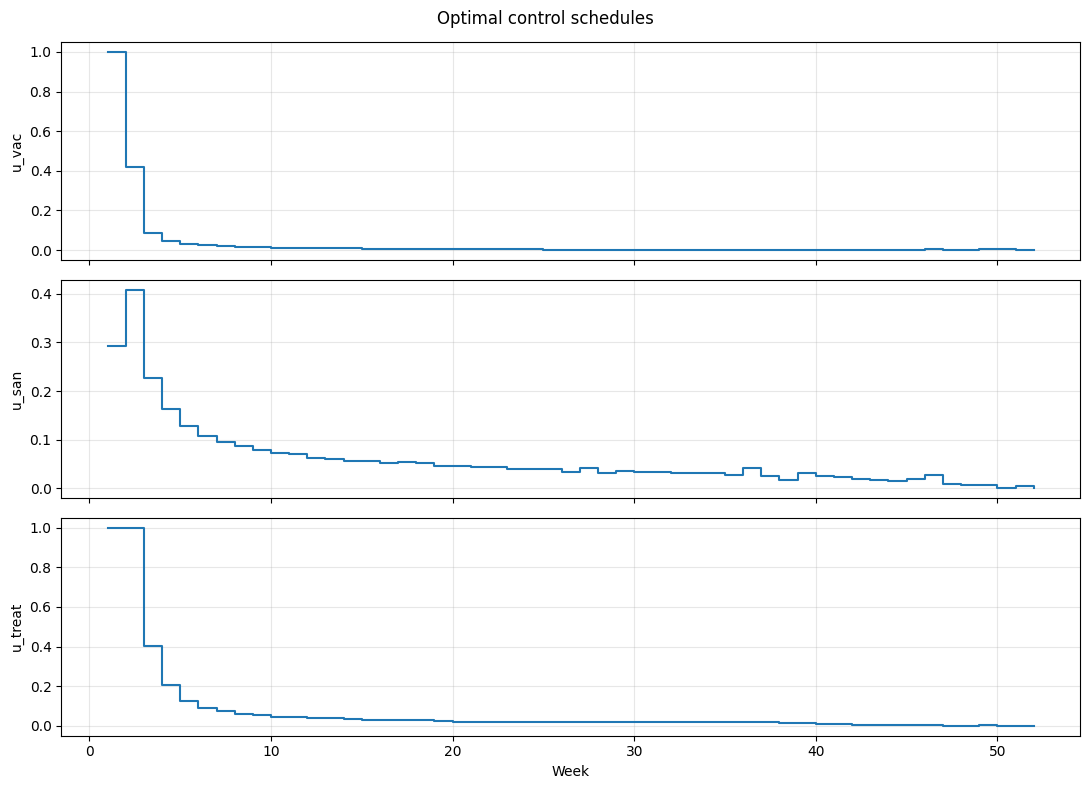

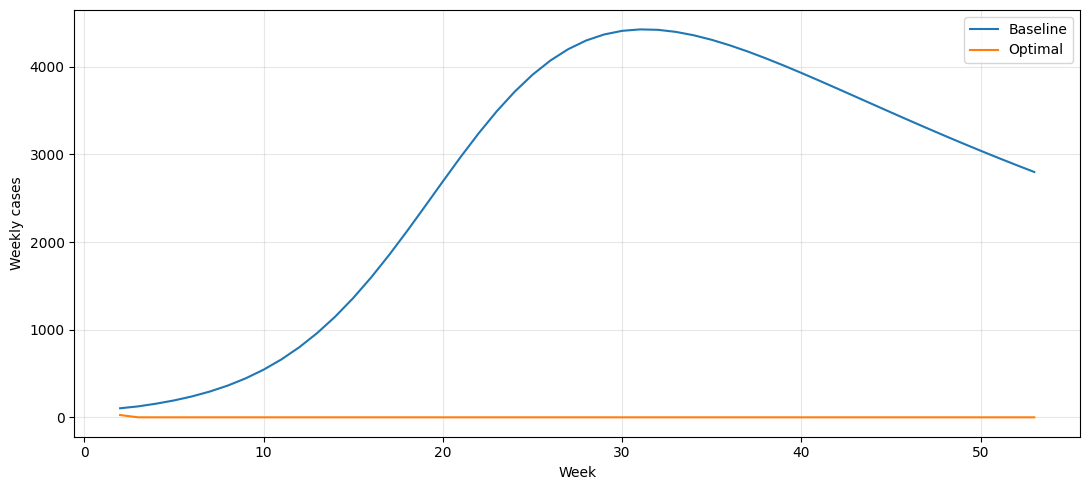

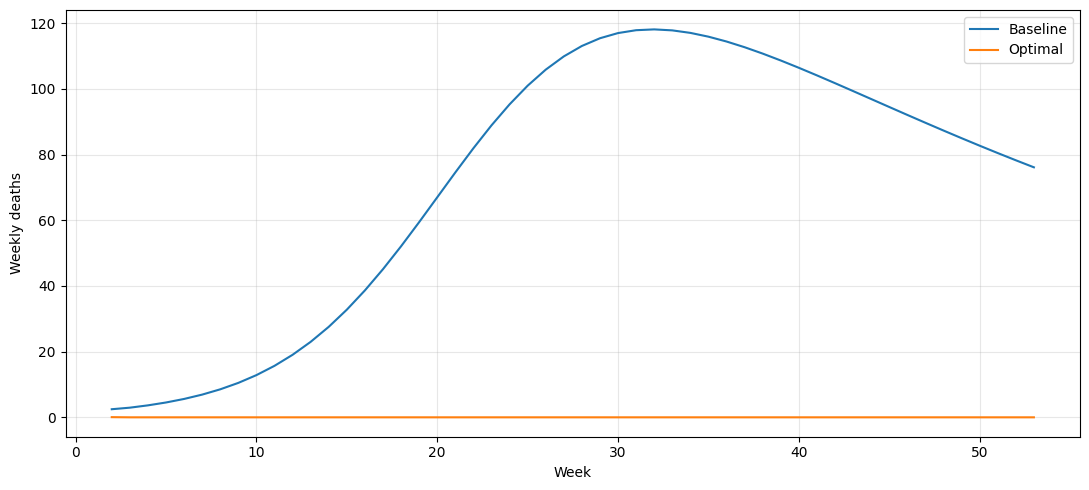

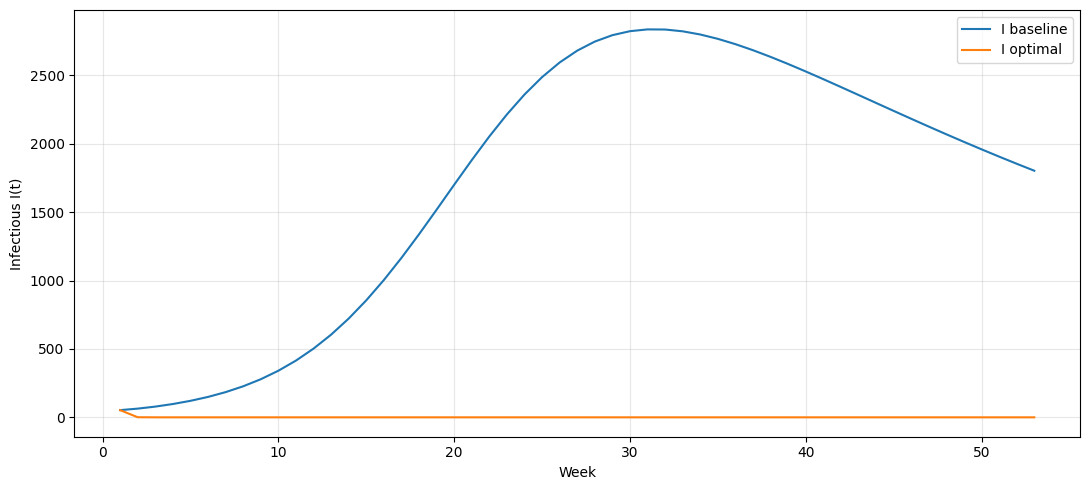

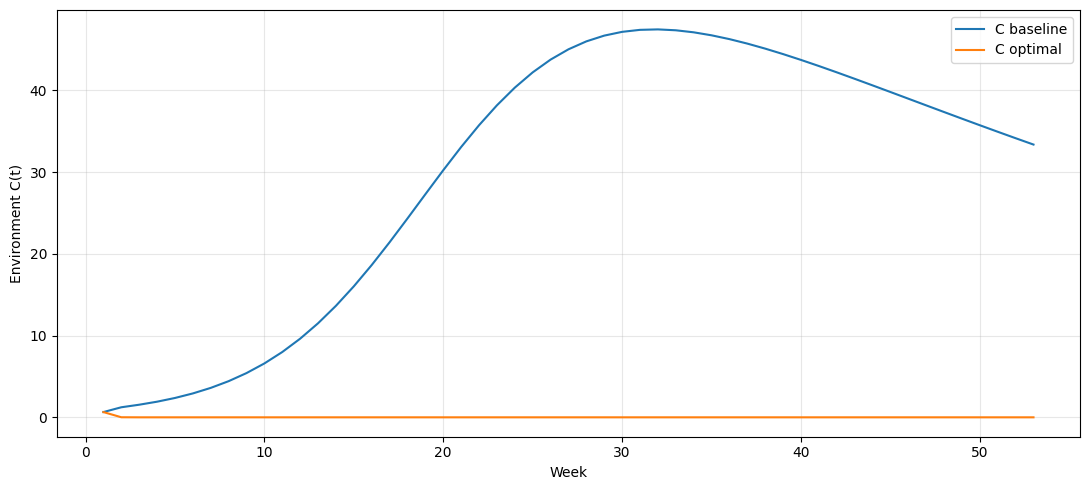

In [13]:
#!/usr/bin/env python3
import os
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

from scipy.optimize import least_squares, minimize, Bounds

from model import Params, ControlGains, simulate
from fit_and_project import (
    weeks as weeks_fit, cases_obs, deaths_obs,  # your data
    theta0, lower, upper, residuals, pack_params, N_POP
)

# ---------------------------------------------
# 0) Fit (reuse your LS fit so μ, γ, etc. are set)
# ---------------------------------------------
def fit_theta():
    sol = least_squares(
        residuals, theta0, bounds=(lower, upper),
        xtol=1e-10, ftol=1e-10, gtol=1e-10, max_nfev=20000
    )
    return sol.x

# ---------------------------------------------
# 1) Piecewise-constant controls, weekly grid
# ---------------------------------------------
def simulate_piecewise(
    weeks_grid: np.ndarray,
    y0: Tuple[float, float, float, float, float, float, float],
    base: Params,
    u_v: np.ndarray, u_s: np.ndarray, u_t: np.ndarray,
):
    """
    Simulate week-by-week; each step uses constant controls for that week.
    """
    assert len(weeks_grid) >= 2
    assert len(u_v) == len(u_s) == len(u_t) == (len(weeks_grid)-1)

    t_all = [weeks_grid[0]]
    traj = {k: [v] for k, v in zip(
        ["S","E","I","R","C","A","D"], y0
    )}
    weekly_cases, weekly_deaths = [], []

    gains = ControlGains()  # leverage your (possibly updated) sanitation/treatment effects

    y_curr = np.array(y0, float)
    for k in range(len(u_v)):
        t0, t1 = weeks_grid[k], weeks_grid[k+1]
        pars = Params(**{**base.__dict__,
                         "u_vac": float(np.clip(u_v[k], 0, 1)),
                         "u_san": float(np.clip(u_s[k], 0, 1)),
                         "u_treat": float(np.clip(u_t[k], 0, 1))})
        # simulate current week
        sol = simulate(np.array([t0, t1], float), tuple(y_curr), pars, gains=gains)
        # append end-of-week state and flows
        for name in ["S","E","I","R","C","cum_inc","cum_deaths"]:
            # take the last value
            v = sol[name][-1]
            if name == "cum_inc":
                weekly_cases.append(v - traj["A"][-1])
                traj["A"].append(v)
            elif name == "cum_deaths":
                weekly_deaths.append(v - traj["D"][-1])
                traj["D"].append(v)
            else:
                traj[name].append(v)
        t_all.append(t1)
        # update current state vector y_curr
        y_curr = np.array([traj["S"][-1], traj["E"][-1], traj["I"][-1],
                           traj["R"][-1], traj["C"][-1], traj["A"][-1], traj["D"][-1]])

    out = dict(
        t=np.array(t_all),
        S=np.array(traj["S"]), E=np.array(traj["E"]), I=np.array(traj["I"]),
        R=np.array(traj["R"]), C=np.array(traj["C"]),
        cum_inc=np.array(traj["A"]), cum_deaths=np.array(traj["D"]),
        weekly_cases=np.array(weekly_cases), weekly_deaths=np.array(weekly_deaths)
    )
    return out

# ---------------------------------------------
# 2) Objective J (quadratic control costs + burden)
# ---------------------------------------------
@dataclass
class OCWeights:
    B_I: float = 1.0   # weight on infectious prevalence I(t)
    B_C: float = 0.1   # weight on environment C(t)
    B_cases: float = 0.0  # optional weight on weekly cases
    B_deaths: float = 10.0  # optional stronger weight on deaths
    A1: float = 0.5    # u_vac^2 penalty
    A2: float = 0.5    # u_san^2 penalty
    A3: float = 0.5    # u_treat^2 penalty

def objective(u_all, weeks_grid, y0, base, w: OCWeights):
    T = len(weeks_grid) - 1
    u_v = np.clip(u_all[0*T:1*T], 0, 1)
    u_s = np.clip(u_all[1*T:2*T], 0, 1)
    u_t = np.clip(u_all[2*T:3*T], 0, 1)

    out = simulate_piecewise(weeks_grid, y0, base, u_v, u_s, u_t)

    # simple Riemann sum with dt=1 week
    I = out["I"][:-1]      # per-interval left endpoints
    C = out["C"][:-1]
    J_state = w.B_I * np.sum(I) + w.B_C * np.sum(C)

    # optional incidence/death penalties (interval values)
    if w.B_cases != 0 or w.B_deaths != 0:
        J_state += w.B_cases * np.sum(out["weekly_cases"])
        J_state += w.B_deaths * np.sum(out["weekly_deaths"])

    # quadratic control costs
    J_ctrl = 0.5 * (w.A1*np.sum(u_v**2) + w.A2*np.sum(u_s**2) + w.A3*np.sum(u_t**2))
    return float(J_state + J_ctrl)

# ---------------------------------------------
# 3) Run optimal control
# ---------------------------------------------
def main():
    # ---- fit parameters
    theta_hat = fit_theta()
    pm = pack_params(theta_hat)
    base = Params(
        N=N_POP, beta1=pm["beta1"], beta2=pm["beta2"], sigma=pm["sigma"],
        gamma=pm["gamma"], mu=pm["mu"], delta=pm["delta"],
        eta=pm["eta"], epsilon=pm["epsilon"], kappa=pm["kappa"],
        # Kc can be added here if you adopted it in model.py (e.g., Kc=10.0)
    )

    # ---- initial conditions derived from fit
    I0 = max(1.0, pm["I0"]); E0 = 0.5*I0; R0 = 0.0
    C0 = max(0.0, pm["C0"]); S0 = base.N - (E0 + I0 + R0)
    y0 = (S0, E0, I0, R0, C0, 0.0, 0.0)

    # ---- horizon & controls
    T_weeks = 52
    weeks_grid = np.arange(weeks_fit[0], weeks_fit[0] + T_weeks + 1, dtype=float)  # step=1
    T = len(weeks_grid) - 1

    # initial guess: zeros
    u0 = np.zeros(3*T, dtype=float)

    # bounds in [0,1]
    bounds = Bounds(lb=np.zeros_like(u0), ub=np.ones_like(u0))

    # weights (tune for pedagogy)
    w = OCWeights(
        B_I=1.0, B_C=0.1, B_cases=0.0, B_deaths=10.0,
        A1=0.05, A2=0.05, A3=0.05  # cheaper controls to show action
    )

    # baseline (no control) for comparison
    out_base = simulate_piecewise(weeks_grid, y0, base,
                                  u_v=np.zeros(T), u_s=np.zeros(T), u_t=np.zeros(T))
    J_base = objective(u0, weeks_grid, y0, base, w)
    print(f"Baseline cost J = {J_base:.3f}")

    # ---- optimize with L-BFGS-B
    def fun(u_vec):
        return objective(u_vec, weeks_grid, y0, base, w)

    res = minimize(fun, u0, method="L-BFGS-B", bounds=bounds,
                   options=dict(maxiter=500, ftol=1e-6))

    print(res.message)
    print(f"Optimal cost J* = {res.fun:.3f}")

    # unpack optimal controls
    u_opt = np.clip(res.x, 0, 1)
    u_v_opt = u_opt[0*T:1*T]; u_s_opt = u_opt[1*T:2*T]; u_t_opt = u_opt[2*T:3*T]

    # simulate under optimal controls
    out_opt = simulate_piecewise(weeks_grid, y0, base, u_v_opt, u_s_opt, u_t_opt)

    os.makedirs("../plots", exist_ok=True)

    # ---- Controls over time
    fig, ax = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
    ax[0].step(weeks_grid[:-1], u_v_opt, where="post"); ax[0].set_ylabel("u_vac")
    ax[1].step(weeks_grid[:-1], u_s_opt, where="post"); ax[1].set_ylabel("u_san")
    ax[2].step(weeks_grid[:-1], u_t_opt, where="post"); ax[2].set_ylabel("u_treat")
    ax[2].set_xlabel("Week"); [a.grid(True, alpha=0.3) for a in ax]
    fig.suptitle("Optimal control schedules")
    fig.tight_layout(); fig.savefig("../plots/oc_controls.png", dpi=200)

    # ---- Outcomes: weekly cases & deaths
    plt.figure(figsize=(11,5))
    plt.plot(out_base["t"][1:], out_base["weekly_cases"], label="Baseline")
    plt.plot(out_opt["t"][1:],  out_opt["weekly_cases"],  label="Optimal")
    plt.xlabel("Week"); plt.ylabel("Weekly cases"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/oc_weekly_cases.png", dpi=200)

    plt.figure(figsize=(11,5))
    plt.plot(out_base["t"][1:], out_base["weekly_deaths"], label="Baseline")
    plt.plot(out_opt["t"][1:],  out_opt["weekly_deaths"],  label="Optimal")
    plt.xlabel("Week"); plt.ylabel("Weekly deaths"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/oc_weekly_deaths.png", dpi=200)

    # ---- Outcomes: I(t) & C(t) trajectories
    plt.figure(figsize=(11,5))
    plt.plot(out_base["t"], out_base["I"], label="I baseline")
    plt.plot(out_opt["t"],  out_opt["I"],  label="I optimal")
    plt.xlabel("Week"); plt.ylabel("Infectious I(t)"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/oc_I_traj.png", dpi=200)

    plt.figure(figsize=(11,5))
    plt.plot(out_base["t"], out_base["C"], label="C baseline")
    plt.plot(out_opt["t"],  out_opt["C"],  label="C optimal")
    plt.xlabel("Week"); plt.ylabel("Environment C(t)"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.savefig("../plots/oc_C_traj.png", dpi=200)

    # quick text summary
    red_cases = 100.0*(1 - out_opt["weekly_cases"].sum() / out_base["weekly_cases"].sum())
    red_deaths = 100.0*(1 - out_opt["weekly_deaths"].sum() / out_base["weekly_deaths"].sum())
    print(f"Reductions vs baseline — Cases: {red_cases:.1f}% | Deaths: {red_deaths:.1f}%")
    print("Saved optimal-control plots in ./plots")

if __name__ == "__main__":
    main()
